# Tagalog Fake News Detector

## Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import string
from spacy.lang.tl.stop_words import STOP_WORDS as tl_stop_words
from spacy.lang.en.stop_words import STOP_WORDS as en_stop_words
import nltk
from nltk import tokenize
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn

## Dataset

In [2]:
data = pd.read_csv("dataset.csv")
data

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
3201,1,Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202,1,"Sa isang pahayag, binatikos ng Liberal Party (..."
3203,1,Panoorin nyo yung reaction video na ito ni Mr....
3204,1,Para sa mga magkakapatid na laging nagtatalo l...


## Data Cleaning

Shuffle the data to prevent bias:

In [3]:
data = shuffle(data)
data = data.reset_index(drop=True)
data

,label,article
0,1,Naaresto sa isinagawang anti-criminality opera...
1,1,Usap-usapan ngayon sa social media ang umano'y...
2,0,"Noong Abril 1931, nang pumanig ang mga botante..."
3,0,Ito ang isiniwalat ni Philippine Amateur Track...
4,1,Usap-usapan ngayon sa social media ang umano'y...
...,...,...
3201,1,"Matapos makasuhan ng tax evasion, cyber libel ..."
3202,1,Hindi nagustuhan ni Kris Aquino ang biro ni da...
3203,0,Emosyonal pa rin ang mga Australian sa kinahin...
3204,0,Sinabi ni Cojuangco na ang akusasyon na may ka...


Convert all article text to lowercase:

In [4]:
data["article"] = data["article"].apply(lambda x: x.lower())
data

,label,article
0,1,naaresto sa isinagawang anti-criminality opera...
1,1,usap-usapan ngayon sa social media ang umano'y...
2,0,"noong abril 1931, nang pumanig ang mga botante..."
3,0,ito ang isiniwalat ni philippine amateur track...
4,1,usap-usapan ngayon sa social media ang umano'y...
...,...,...
3201,1,"matapos makasuhan ng tax evasion, cyber libel ..."
3202,1,hindi nagustuhan ni kris aquino ang biro ni da...
3203,0,emosyonal pa rin ang mga australian sa kinahin...
3204,0,sinabi ni cojuangco na ang akusasyon na may ka...


Remove punctuations from article text:

In [5]:
def remove_punctuation(text):
    no_puncs = [char for char in text if char not in string.punctuation]
    clean = "".join(no_puncs)
    
    return clean

data["article"] = data["article"].apply(remove_punctuation)
data

,label,article
0,1,naaresto sa isinagawang anticriminality operat...
1,1,usapusapan ngayon sa social media ang umanoy p...
2,0,noong abril 1931 nang pumanig ang mga botante ...
3,0,ito ang isiniwalat ni philippine amateur track...
4,1,usapusapan ngayon sa social media ang umanoy p...
...,...,...
3201,1,matapos makasuhan ng tax evasion cyber libel a...
3202,1,hindi nagustuhan ni kris aquino ang biro ni da...
3203,0,emosyonal pa rin ang mga australian sa kinahin...
3204,0,sinabi ni cojuangco na ang akusasyon na may ka...


Remove stop words:

In [6]:
data["article"] = data["article"].apply(lambda x: " ".join([word for word in x.split() if word not in (tl_stop_words)]))
data["article"] = data["article"].apply(lambda x: " ".join([word for word in x.split() if word not in (en_stop_words)]))
data

,label,article
0,1,naaresto isinagawang anticriminality operation...
1,1,usapusapan social media umanoy panggagaya kina...
2,0,noong abril 1931 nang pumanig botante liberal ...
3,0,isiniwalat philippine amateur track field asso...
4,1,usapusapan social media umanoy panggagaya kina...
...,...,...
3201,1,matapos makasuhan tax evasion cyber libel maka...
3202,1,nagustuhan kris aquino biro dating special ass...
3203,0,emosyonal rin australian kinahinatnan balitang...
3204,0,sinabi cojuangco akusasyon karagdagang p1 bily...


## Exploratory Data Analysis

Fake/real splits:

Text(0.5, 1.0, 'Data Splits Labelled Fake (0) and True (1)')

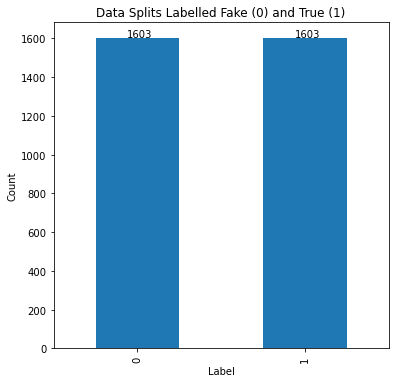

In [7]:
data.groupby(["label"]).size().plot(kind="bar", figsize=[6,6])
plt.xlabel("Label")
plt.ylabel("Count")
plt.text(-0.06, 1608, len(data.loc[data["label"] == 0]))
plt.text(0.94, 1608, len(data.loc[data["label"] == 1]))
plt.title("Data Splits Labelled Fake (0) and True (1)")

Most frequent words for fake and real news:

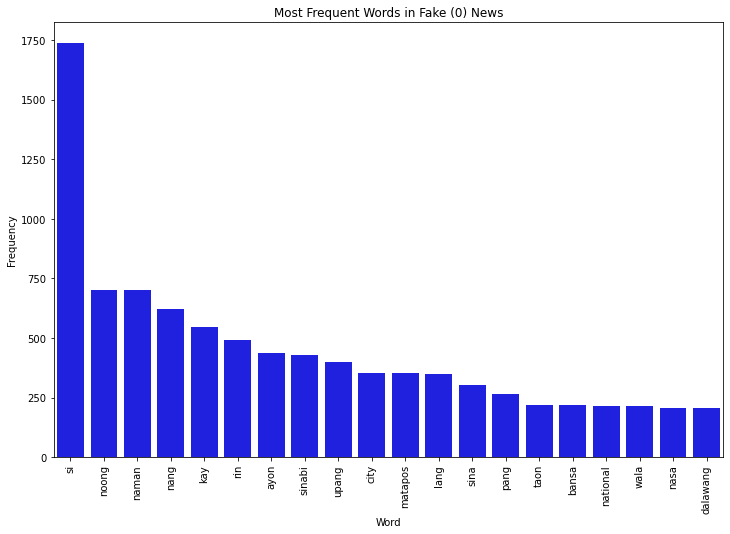

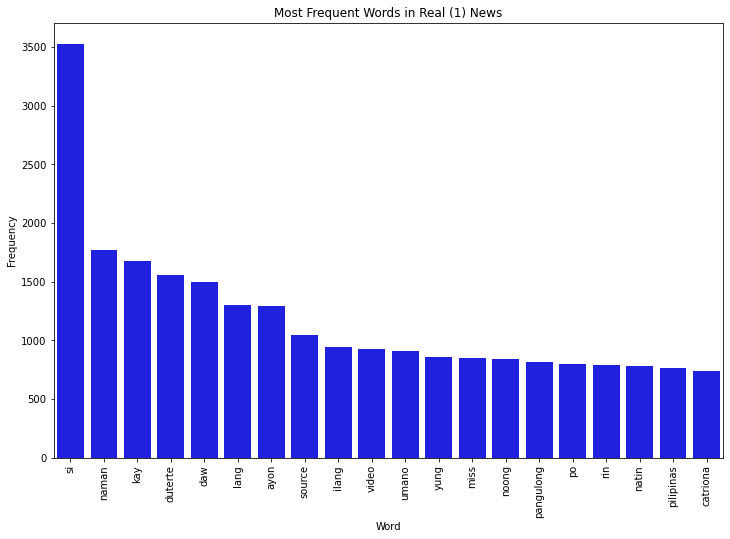

In [8]:
# Code adopted from https://www.kaggle.com/rodolfoluna/fake-news-detector

rows = data[data["label"] == 0]
all_words = " ".join([rows for rows in rows["article"]])
token_space = tokenize.WhitespaceTokenizer()
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns="Frequency", n=20)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_frequency, x="Word", y="Frequency", color="blue").set_title("Most Frequent Words in Fake (0) News")
plt.xticks(rotation="vertical")
plt.show()

rows = data[data["label"] == 1]
all_words = " ".join([rows for rows in rows["article"]])
token_space = tokenize.WhitespaceTokenizer()
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns="Frequency", n=20)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_frequency, x="Word", y="Frequency", color="blue").set_title("Most Frequent Words in Real (1) News")
plt.xticks(rotation="vertical")
plt.show()

# Modelling

In [9]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data["article"], data["label"], random_state=2018, test_size=0.3, stratify=data["label"])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [11]:
model = AutoModel.from_pretrained("jcblaise/bert-tagalog-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("jcblaise/bert-tagalog-base-uncased", do_lower_case=True)

Some weights of the model checkpoint at jcblaise/bert-tagalog-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

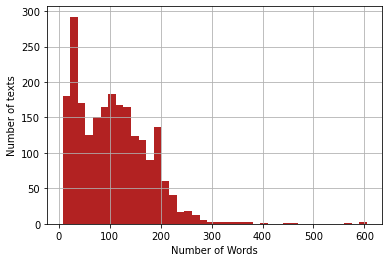

In [12]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40, color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [13]:
MAX_LENGHT = 200
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [20]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1. 1.]


In [22]:
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [23]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    #print(type(labels),type(mask),type(sent_id))
    #print(sent_id)
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [24]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [25]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [26]:

#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_weights.pt'